In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
%ls evaluate/seed-experiment-results/joint/aggregate

aggregate-seed-experiment-results-040920.csv
aggregate-seed-experiment-results-041120.csv


In [4]:
seed_experiment_results = pd.read_csv('evaluate/seed-experiment-results/joint/aggregate/aggregate-seed-experiment-results-041120.csv')

In [5]:
seed_experiment_results

,seed,language_pair,bleu,bpe
0,10,en-ne,4.42,2500
1,10,en-si,1.64,2500
2,10,ne-en,7.59,2500
3,10,si-en,6.69,2500
4,11,en-ne,4.33,2500
...,...,...,...,...
115,18,si-en,6.65,7500
116,19,en-ne,4.44,7500
117,19,en-si,1.32,7500
118,19,ne-en,7.44,7500


## Bayesian model

We'll begin by fitting a simple linear model:

$$
\text{BLEU}^l = \eta^l + \tau^l_{b} + \mu^l_j + \epsilon
$$

We also give all parameter vectors a common prior distribution:

$$
\theta \sim N(0,1)\text{ for all }\theta \in \{\eta, \tau, \mu, \epsilon\}
$$

Since we repeated the experiments with seeds, we'll get an idea of "sampling variation" here as well.

In [6]:
import pymc3 as pm
from sklearn.preprocessing import LabelEncoder

In [7]:
bpe_enc = LabelEncoder()
lang_pair_enc = LabelEncoder()

In [8]:
lang_pair_data = lang_pair_enc.fit_transform(seed_experiment_results.language_pair)
bpe_data = bpe_enc.fit_transform(seed_experiment_results.bpe)
bleu_data = seed_experiment_results.bleu

In [9]:
n_lang_pairs = 4
n_bpes = 3

First fit a global model that is language-agnostic:

In [10]:
with pm.Model() as linear_model:
    
    eta = pm.Normal('eta', mu=0, sigma=1)
    tau = pm.Normal('tau', mu=0, sigma=1, shape=n_bpes)
    b = eta + tau[bpe_data]
    noise = pm.HalfCauchy('noise', 5)

    bleu_observed = pm.Normal('bleu_observed',
                              mu=b,
                              sigma=noise,
                              observed=bleu_data)

    prior = pm.sample_prior_predictive()
    posterior = pm.sample()
    posterior_pred = pm.sample_posterior_predictive(posterior)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, tau, eta]
100%|██████████| 2000/2000 [00:02<00:00, 922.28it/s]


In [11]:
pm.sample_posterior_predictive?

In [79]:
def posterior_predictive_check():
    criticism = pd.DataFrame()
    rand_ix = np.random.randint(low=0, high=2000)
    criticism['bleu_fake'] = posterior_pred['bleu_observed'][rand_ix]
    criticism['bleu_obs'] = bleu_data
    criticism.plot(kind='hist', alpha=0.7, title='Posterior predictive check: BLEU', figsize=(12,6), bins=30)

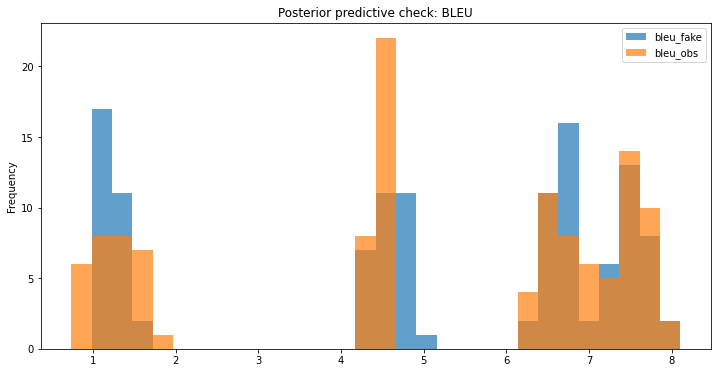

In [80]:
# model criticism
posterior_predictive_check()

Clearly fitting a single model is not the right thing to do here. We can also fit separate models:

In [81]:
combined_lp_bpe = list(zip(seed_experiment_results.language_pair, seed_experiment_results.bpe))

In [82]:
combo_enc = LabelEncoder()

In [83]:
combined_lp_bpe = [f"{t[0]}-{t[1]}" for t in combined_lp_bpe]

In [84]:
combined_lp_bpe_data = combo_enc.fit_transform(combined_lp_bpe)

In [85]:
n_combined = 12

In [86]:
def fit_shared_model(n=2000):
        
    bleu_model = pm.Model()
    with bleu_model:

        eta = pm.Normal('eta', mu=0, sigma=1, shape=n_lang_pairs)
        tau = pm.Normal('tau', mu=0, sigma=1, shape=n_combined)
        b = eta[lang_pair_data] + tau[combined_lp_bpe_data]
        noise = pm.HalfCauchy('noise', 5)

        bleu_observed = pm.Normal('bleu_observed',
                                  mu=b,
                                  sigma=noise,
                                  observed=bleu_data)

        prior = pm.sample_prior_predictive(samples=n)
        posterior = pm.sample(draws=n)
        posterior_pred = pm.sample_posterior_predictive(posterior, samples=n)
        
    return bleu_model, prior, posterior, posterior_pred

In [87]:
m2, prior, posterior, posterior_pred = fit_shared_model(n=10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, tau, eta]
Sampling 4 chains, 0 divergences: 100%|██████████| 42000/42000 [02:20<00:00, 299.38draws/s]
/home/think/miniconda3/envs/work/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 10000/10000 [00:10<00:00, 910.13it/s]


In [88]:
[x for x in dir(pm) if x.endswith('plot')]

['autocorrplot',
 'compareplot',
 'densityplot',
 'energyplot',
 'forestplot',
 'kdeplot',
 'pairplot',
 'traceplot']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f56e7733750>,
      dtype=object)

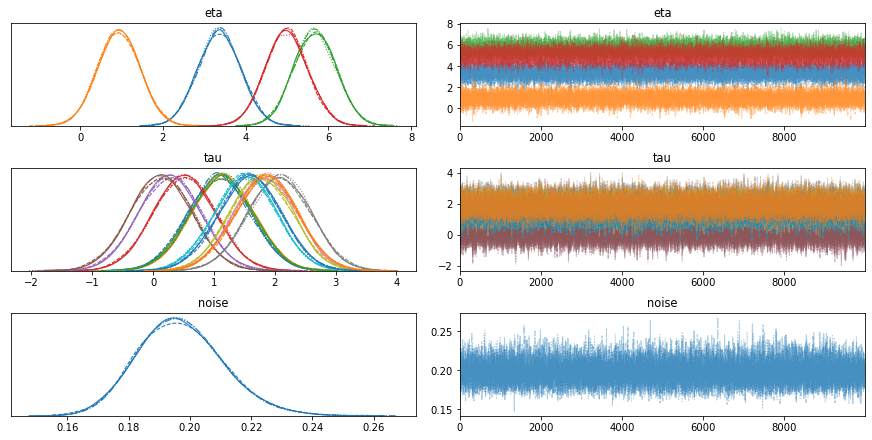

In [89]:
pm.traceplot(posterior)

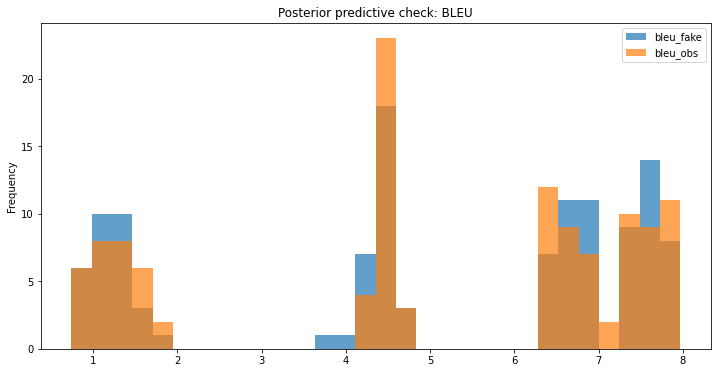

In [100]:
posterior_predictive_check()

A much, much better fit!

## Investigating the coefficients

In [109]:
tau_names = combo_enc.inverse_transform([i for i in range(n_combined)]).tolist()

In [114]:
tau_name2ix = {tau_names[i]: i for i in range(n_combined)}

In [116]:
tau_posterior = posterior['tau']

In [130]:
tau_df = pd.DataFrame({tn: tau_posterior[:, tau_name2ix[tn]] for tn in tau_names})

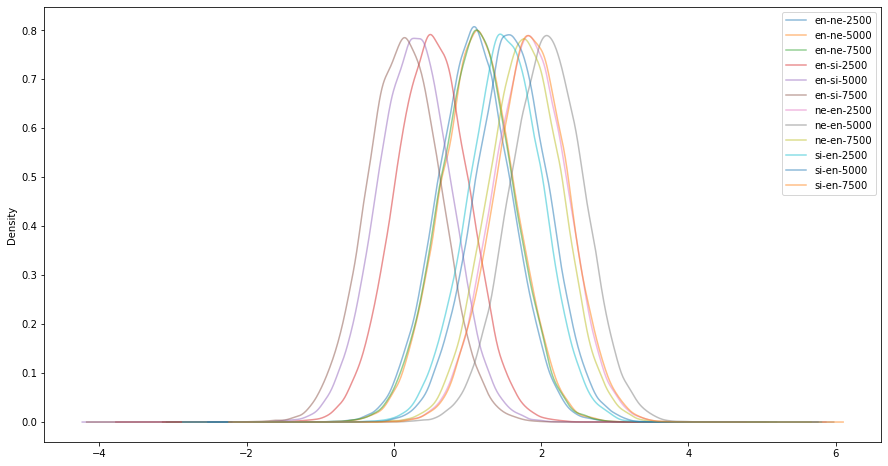

In [136]:
tau_df.plot(kind='kde', alpha=0.5, figsize=(15,8))

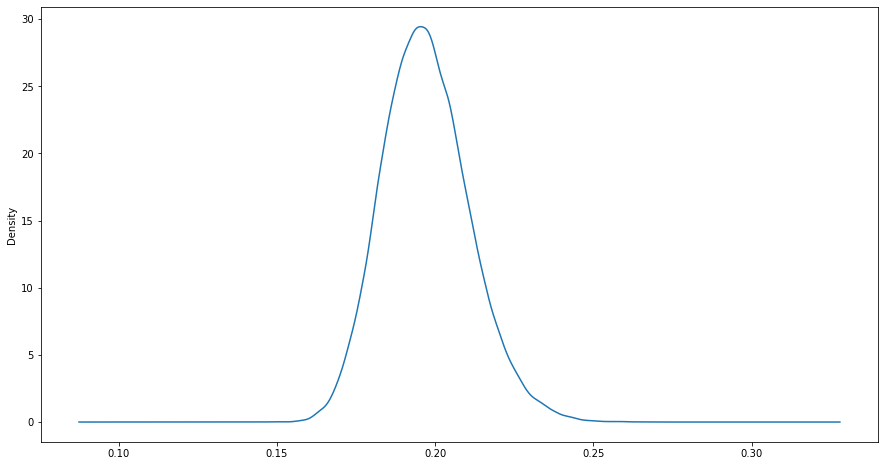

In [140]:
pd.Series(posterior['noise']).plot(kind='kde', figsize=(15, 8))

In [154]:
def plot_lang_pair(lang_pair, cmap):
    tau_df[[c for c in tau_df.columns if lang_pair in c]]\
        .plot(kind='kde', figsize=(15, 8), cmap=cmap)

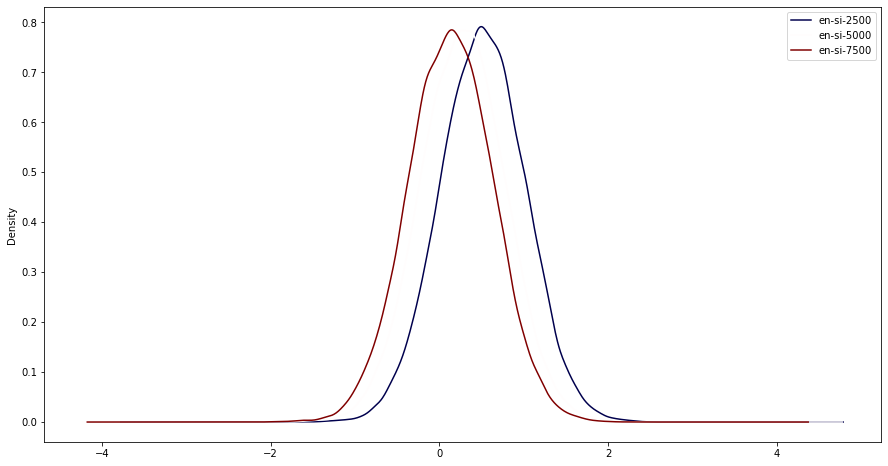

In [159]:
plot_lang_pair('en-si', cmap='seismic')

In [164]:
def plot_bpe(bpe, cmap):
    tau_df[[c for c in tau_df.columns if str(bpe) in c]]\
        .plot(kind='kde', figsize=(15, 8), cmap=cmap)

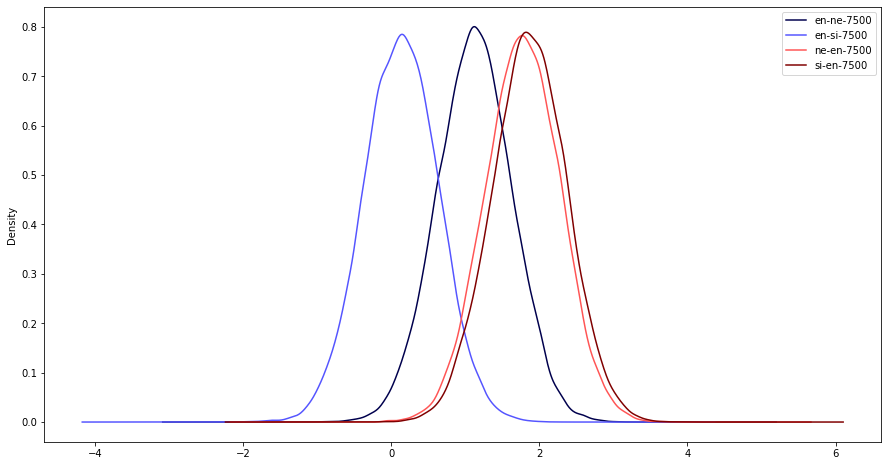

In [169]:
plot_bpe(7500, 'seismic')

In [173]:
import arviz

In [182]:
posterior['tau'].shape

(40000, 12)

In [185]:
import string

In [190]:
p = string.punctuation

In [200]:
pm.forestplot?

In [211]:
print("Legend:")
for ix in range(12):
    print(f'\t- tau{ix} = tau-{combo_enc.inverse_transform([ix])[0]}')

Legend:
	- tau0 = tau-en-ne-2500
	- tau1 = tau-en-ne-5000
	- tau2 = tau-en-ne-7500
	- tau3 = tau-en-si-2500
	- tau4 = tau-en-si-5000
	- tau5 = tau-en-si-7500
	- tau6 = tau-ne-en-2500
	- tau7 = tau-ne-en-5000
	- tau8 = tau-ne-en-7500
	- tau9 = tau-si-en-2500
	- tau10 = tau-si-en-5000
	- tau11 = tau-si-en-7500


In [218]:
arviz.convert_to_dataset?

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f56ee42e390>],
      dtype=object)

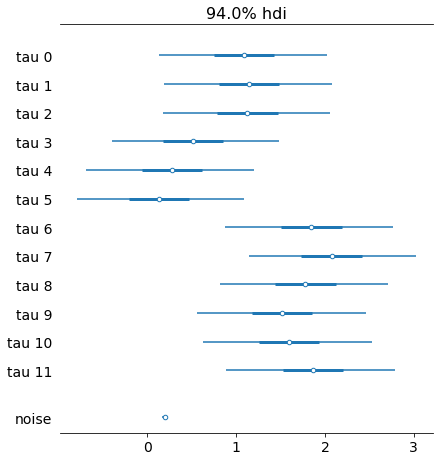

In [208]:
pm.forestplot(posterior, combined=True, var_names=['~eta'])

In [216]:
posterior_pred['bleu_observed'][0]

array([4.43918851, 1.73547949, 7.20963037, 6.17173345, 4.83437332,
       1.37797325, 7.59490058, 6.8228135 , 4.59115509, 1.561688  ,
       7.8392806 , 6.4068067 , 4.32976575, 1.52861578, 7.39634824,
       6.35508838, 4.58993236, 1.46346609, 7.62311483, 6.19894081,
       4.24541169, 1.70423395, 7.24408844, 6.27137958, 4.76461581,
       1.3726288 , 7.50381176, 6.47320866, 4.58741986, 1.63334391,
       7.40896581, 6.48575575, 4.37241095, 1.41449098, 7.60675227,
       6.36815869, 4.32847239, 1.8094689 , 7.83579912, 6.47846073,
       4.06111406, 1.27577261, 7.59094111, 6.65022413, 4.27733909,
       1.30877022, 7.41421339, 6.65020644, 4.47278116, 1.17480737,
       7.70496515, 6.81933765, 4.63492121, 1.17719547, 7.8662217 ,
       6.41997781, 4.53906183, 1.08623528, 7.78107231, 6.39453055,
       4.19392331, 1.28841853, 7.54826007, 6.76670833, 4.05253356,
       1.10711408, 7.74238591, 6.44049085, 4.44305702, 1.11981748,
       7.7508947 , 6.64917577, 4.3467151 , 1.30226872, 7.77805

## Plots

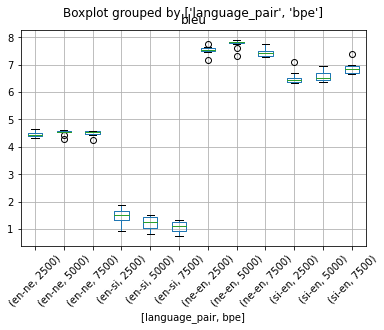

In [5]:
seed_experiment_results\
    .drop('seed', 1)\
    .set_index('bpe')\
    .boxplot(by=['language_pair','bpe'], rot=45)

In [6]:
import seaborn as sns

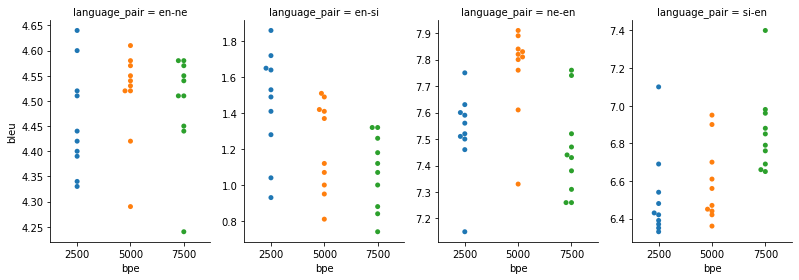

In [7]:
sns.catplot(x="bpe", y="bleu", col="language_pair",
            data=seed_experiment_results, kind="swarm",
            height=4, aspect=.7, sharex=False, sharey=False);

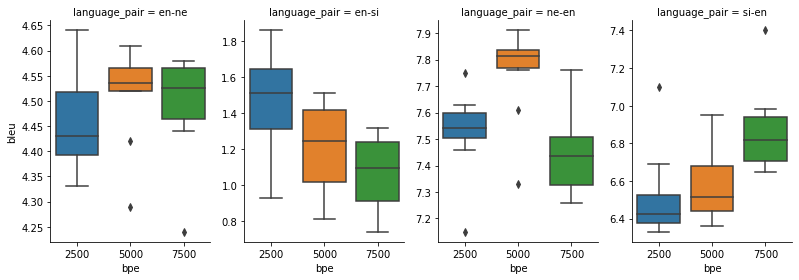

In [8]:
sns.catplot(x="bpe", y="bleu", col="language_pair",
            data=seed_experiment_results, kind="box",
            height=4, aspect=.7, sharex=False, sharey=False);

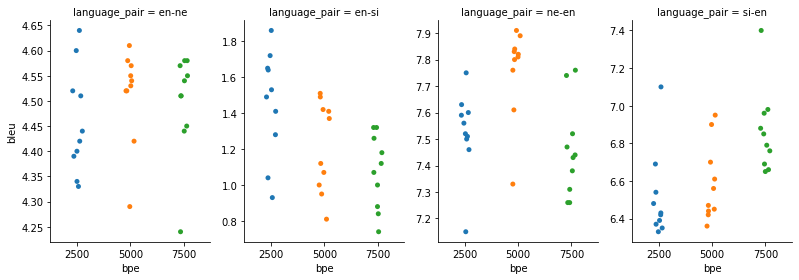

In [9]:
sns.catplot(x="bpe", y="bleu", col="language_pair",
            data=seed_experiment_results, kind="strip",
            height=4, aspect=.7, sharex=False, sharey=False)

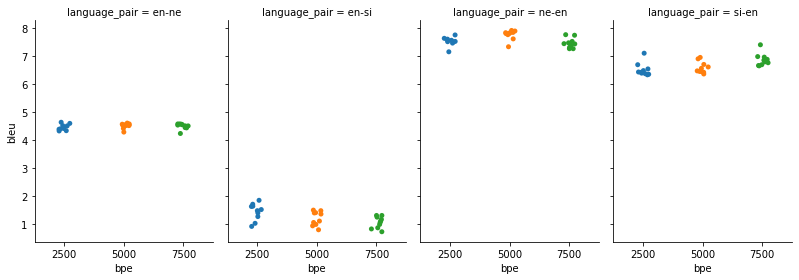

In [17]:
sns.catplot(x="bpe", y="bleu", col="language_pair",
            data=seed_experiment_results, kind="strip",
            height=4, aspect=.7, sharex=False, sharey=True)

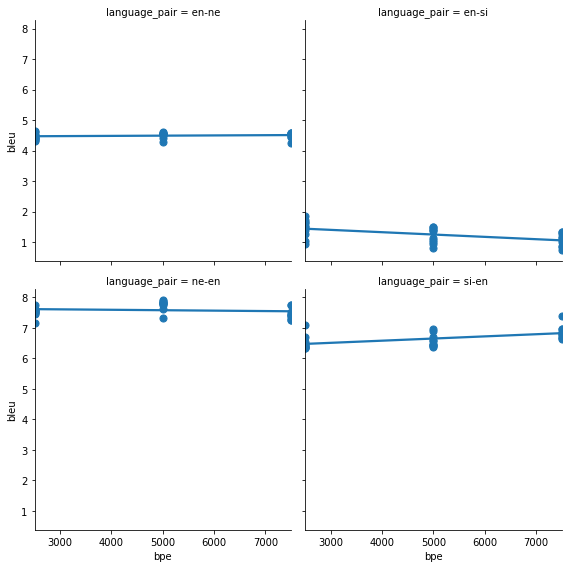

In [19]:
sns.lmplot(x="bpe", y="bleu", col="language_pair", data=seed_experiment_results,
           col_wrap=2, ci=None, palette="muted", height=4,
           scatter_kws={"s": 50, "alpha": 1})